# Demo Notebook for exsiting workflow

The best method for creating multi-source fused data visualisations is to use Datashader.

The source data is pointed into an xarray via either of the xarray libraries (xarray handles standard data formats, rioxarray handles raster based data such as GeoTIFF)


In [1]:
import warnings
warnings.filterwarnings('ignore') # Mutes serialization warnings

In [2]:
import rioxarray
import xarray as xr
import datashader as ds
import netCDF4 as nc
import cartopy.crs as ccrs
import iris
from cmocean import cm as cmo
from datashader import transfer_functions as tf
from cartopy import feature as cfeature

ModuleNotFoundError: No module named 'rioxarray'

In [8]:
# Open Pop Data
pop_data = '/home/users/adamwa/OceanDataFusion/gpw_v4_population_density_adjusted_to_2015_unwpp_country_totals_rev11_2000_30_sec.tif'
# https://sedac.ciesin.columbia.edu/data/set/gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals-rev11 GeoTIFF, 30sec, Yr 2000

pop_data_ds = rioxarray.open_rasterio(
    pop_data,
    chunks=True,
    lock=False)

sst_data = '/gws/nopw/j04/nemo_vol1/ORCA0083-N006/means/2000/ORCA0083-N06_2000m06T.nc' # Requires JASMIN access


sst_data_nc = nc.Dataset(sst_data, mode='r') 
sst_data_ds = xr.open_dataset(xr.backends.NetCDF4DataStore(sst_data_nc))

In [9]:
# Using iris to reproject the SST data
sst_data_cube = iris.load_cube(sst_data, 'sea_surface_temperature')
sst_data_cube_reproj, extent = iris.analysis.cartography.project(
        sst_data_cube, ccrs.PlateCarree(), nx=4000, ny=2000
    )
# add crs
sst_data_da = xr.DataArray.from_iris(sst_data_cube_reproj)[0]
sst_data_da = sst_data_da.rio.write_crs("epsg:4326")



In [13]:
# convert pop to dataarray
pop_data_da = xr.DataArray(pop_data_ds, name='pop')[0]
# select all data above 0
pop_data_da = pop_data_da.where(pop_data_da > 0)
# reverse y axis
pop_data_da = pop_data_da.reindex(y=pop_data_da.y[::-1])




AttributeError: 'NaturalEarthFeature' object has no attribute 'geometry'

## Canvasing and Shading

Next, we utilise the power of datashader - allowing us to rapidly plot millions of data points. 

1. First we create a canvas, and specify the hight/width in pixels.
2. Next we rasterise the data, aggregating our data into a pixel grid matching that of the canvas.
3. Then we shade the data, here we can choose a colormap, as well as the interpolation of the colourmap (‘eq_hist’ [default], ‘cbrt’ (cube root), ‘log’ (logarithmic), and ‘linear’.). This defines an RGBA pixel color for each aggregated data point.
4. The shades are then stacked. We have been careful to not populate empty pixels in each raster, allowing us to plot both land and sea data simultaneously.
5. The background is then set to grey to highlight missing data points
6. Export to png!

Having different degrees of precision in your data can lead to some pretty rough outlines. Combined with a lack of data leads to empty boxes. 

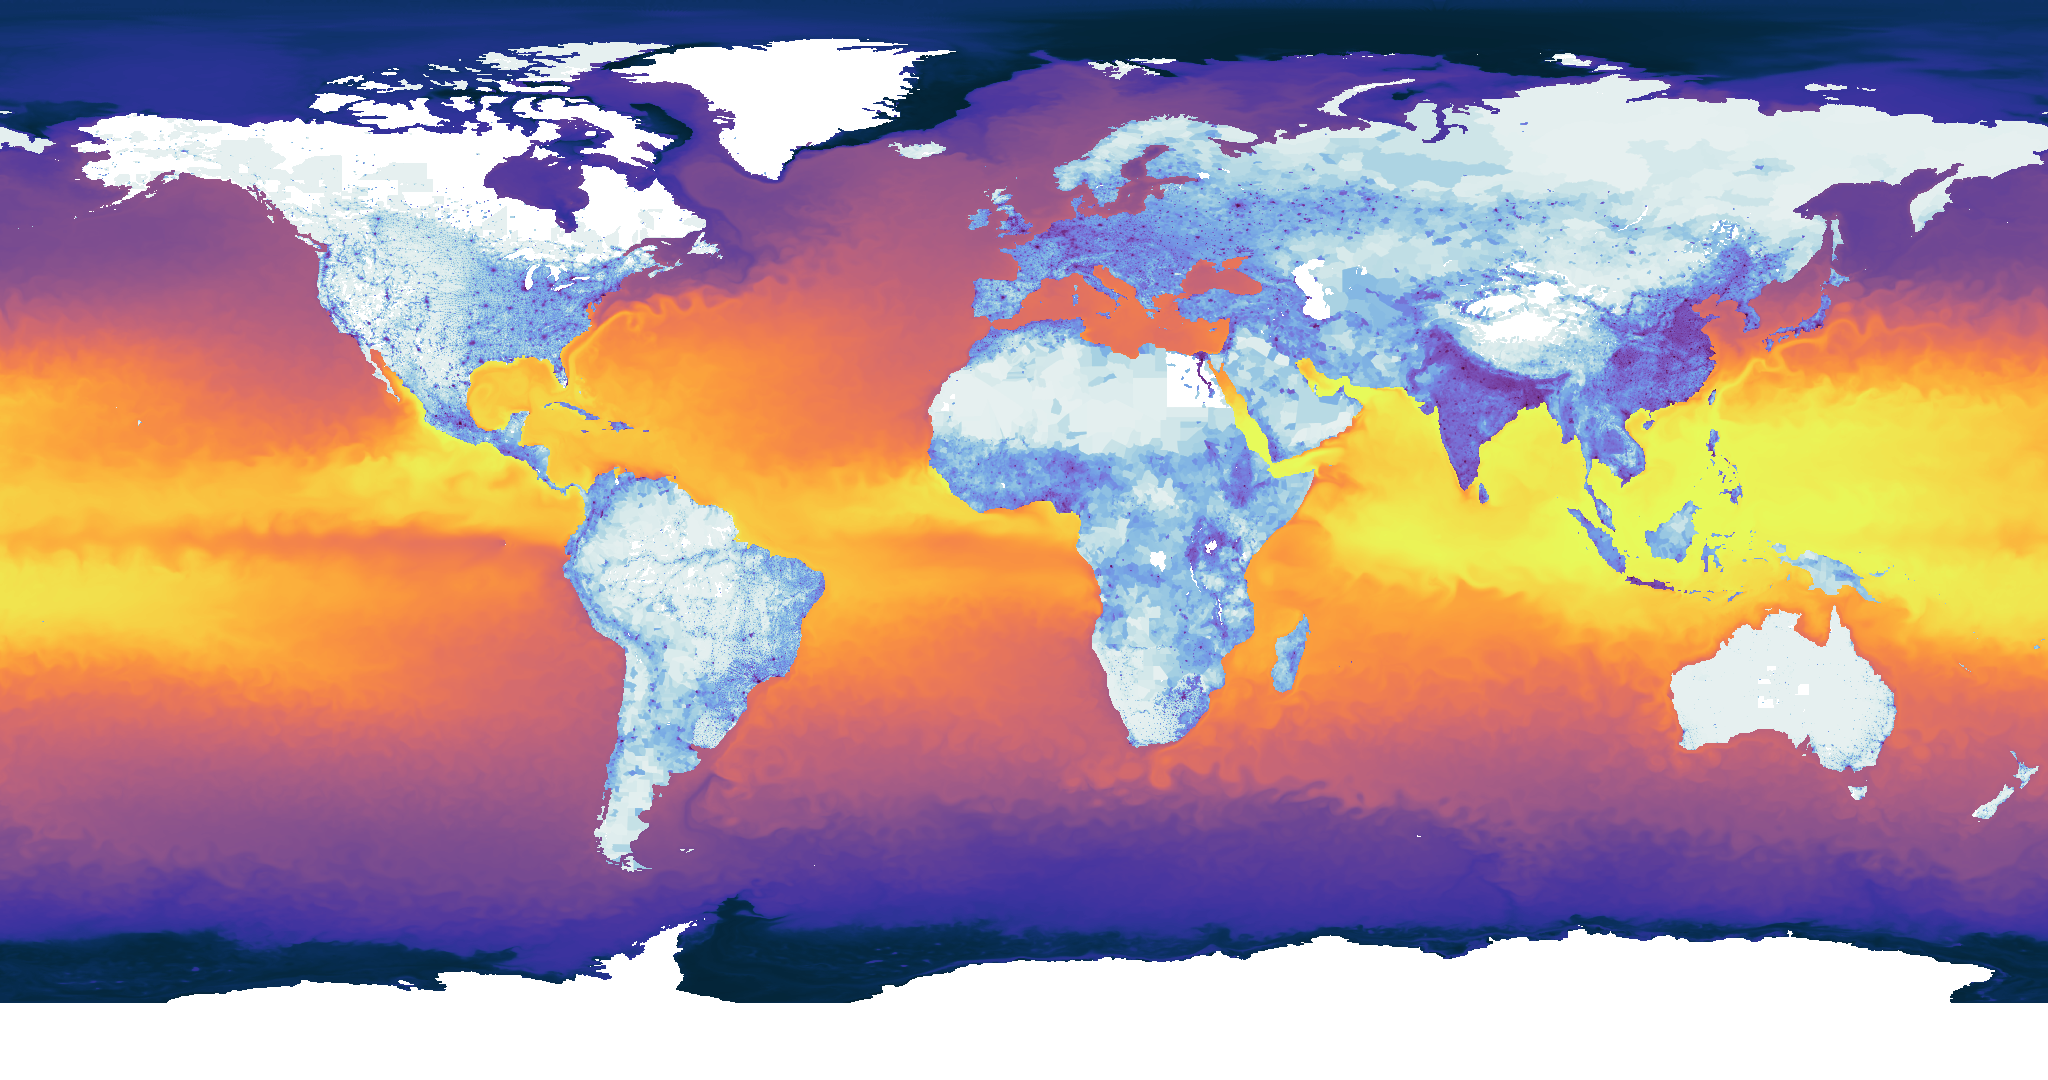

In [14]:
cvs = ds.Canvas(plot_width=2048, plot_height=1080)

# Create a datashader Image by aggregating the data into a grid
sst_agg = cvs.raster(sst_data_da, agg=ds.mean('sst'))
pop_agg = cvs.raster(pop_data_da, agg=ds.mean('pop'))

# shade each raster
sst_img = tf.shade(sst_agg, cmap=cmo.thermal, how='eq_hist')
pop_img = tf.shade(pop_agg, cmap=cmo.dense, how='log')

# stack the images
img = tf.stack(pop_img, sst_img)
img = tf.set_background(img, 'white')

# save the image
ds.utils.export_image(img, 'images/pop_sst', fmt='.png')
